# Cell State Dissection

Using ideas from the FineClustering analysis to dissect the major cell states in the data.

In [1]:
library(SnapATAC)
library(reshape2)
library(viridis)
library(scales)
library(ggplot2)
library(ggrepel)
library(DESeq2)
library(ClusterR)
library(RColorBrewer)
library(patchwork)
library(cowplot)
library(edgeR)

Loading required package: Matrix

Loading required package: rhdf5

Loading required package: viridisLite


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:SnapATAC’:

    colMeans, colSums, rowMeans, rowSums


The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated,

In [2]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

In [3]:
DAYS = c()
FILE_PREFIX = "/srv/scratch/surag/scATAC-reprog/snap"

file.list = c()
barcode.file.list = c()

for (i in seq(0, 14, 2)) {
    DAYS = c(DAYS, sprintf("D%d", i))
    file.list = c(file.list, sprintf("%s/D%d.snap", FILE_PREFIX, i))
}
DAYS
file.list

[1] "D0"  "D2"  "D4"  "D6"  "D8"  "D10" "D12" "D14"

[1] "/srv/scratch/surag/scATAC-reprog/snap/D0.snap" 
[2] "/srv/scratch/surag/scATAC-reprog/snap/D2.snap" 
[3] "/srv/scratch/surag/scATAC-reprog/snap/D4.snap" 
[4] "/srv/scratch/surag/scATAC-reprog/snap/D6.snap" 
[5] "/srv/scratch/surag/scATAC-reprog/snap/D8.snap" 
[6] "/srv/scratch/surag/scATAC-reprog/snap/D10.snap"
[7] "/srv/scratch/surag/scATAC-reprog/snap/D12.snap"
[8] "/srv/scratch/surag/scATAC-reprog/snap/D14.snap"

In [4]:
x.sp.ls = lapply(seq(file.list), function(i) {
    x.sp = createSnap(file = file.list[i],                      
                     sample = DAYS[i])
    x.sp
})

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...



In [5]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20200220_n74838/metadata.tsv", header = T)
metaData$barcode = lapply(strsplit(rownames(metaData), '_'), "[[", 2)
metaData = metaData[order(rownames(metaData)), ]
head(metaData, 2)

sample umap.1   umap.2    cluster barcode         
D0_AAACAACGACGATTAC D0     6.545686 -7.701751 2       AAACAACGACGATTAC
D0_AAACAACGACTCACGG D0     5.180663 -7.633298 2       AAACAACGACTCACGG

In [6]:
# Filter cells 
x.sp.list = lapply(seq(x.sp.ls), function(i){
  x.sp = x.sp.ls[[i]];
  x.sp  = x.sp[x.sp@barcode %in% metaData[as.character(metaData$sample)==DAYS[i], "barcode"],];
})
names(x.sp.list) = DAYS;

In [7]:
x.sp.list = lapply(seq(x.sp.list), function(i) {
    x.sp = addPmatToSnap(x.sp.list[[i]], num.cores=5)
    x.sp
})

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...



In [8]:
# merge timepoints
x.sp = Reduce(snapRbind, x.sp.list);

Warning message:
“'rBind' is deprecated.
 Since R version 3.2.0, base's rbind() should work fine with S4 objects”


In [9]:
# order by sample_barcode
x.sp = x.sp[order(paste(x.sp@sample, x.sp@barcode, sep='_')), ]

In [10]:
# Note that the peaks matrix is not binarized

In [11]:
x.sp@cluster = factor(metaData$cluster)
slot(x.sp, "umap") = as.matrix(metaData[, c("umap.1", "umap.2")])

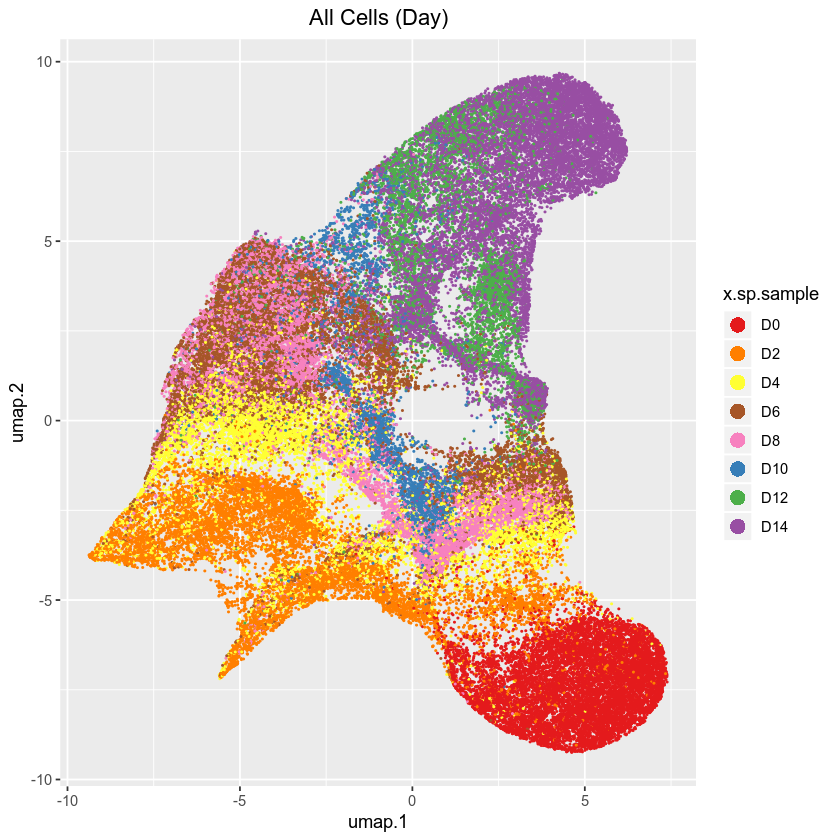

In [12]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=x.sp.sample)) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

## Finer Clustering

In [13]:
library(RANN)
library(leiden)

In [14]:
feats = read.table("../20200206_pmat_snapATAC/sessions/20200220_n74838/features.tsv", header = T)
feats = feats[order(rownames(feats)),]
feats = feats[, 5:ncol(feats)]
head(feats,3)

X1           X2          X3          X4          
D0_AAACAACGACGATTAC -0.009506306 0.003827220 0.004101834 -0.009462710
D0_AAACAACGACTCACGG -0.009003734 0.002892498 0.004525334 -0.004391663
D0_AAACAACGAGCGCACT -0.009416234 0.003781612 0.004398451 -0.006866973
                    X5           X6           X7          X8         
D0_AAACAACGACGATTAC 0.0016989356 -0.006388548 0.004262987 0.003578299
D0_AAACAACGACTCACGG 0.0009756110 -0.010070413 0.005721408 0.003989271
D0_AAACAACGAGCGCACT 0.0005773408 -0.007889277 0.005984896 0.004210641
                    X9           
D0_AAACAACGACGATTAC -0.0055907033
D0_AAACAACGACTCACGG  0.0005145822
D0_AAACAACGAGCGCACT -0.0032638603

In [15]:
K = 15

nn.ranked <- nn2(
        data = feats,
        k = K,
        searchtype = 'standard',
        eps = 0)$nn.idx;

j <- as.numeric(x = t(x = nn.ranked))
i <- ((1:length(x = j)) - 1) %/% K + 1
edgeList = data.frame(i, j, 1);
kmat = Matrix(0, nrow(feats), nrow(feats), sparse=TRUE);
kmat = sparseMatrix(i = edgeList[,1], j = edgeList[,2], x = edgeList[,3]);
nn_graph = SnapATAC:::newKgraph(mat=kmat, k=K, snn=FALSE, snn.prune=1/15);

In [ ]:
clusters = leiden(SnapATAC:::getGraph(nn_graph), resolution=2)

In [ ]:
table(clusters)

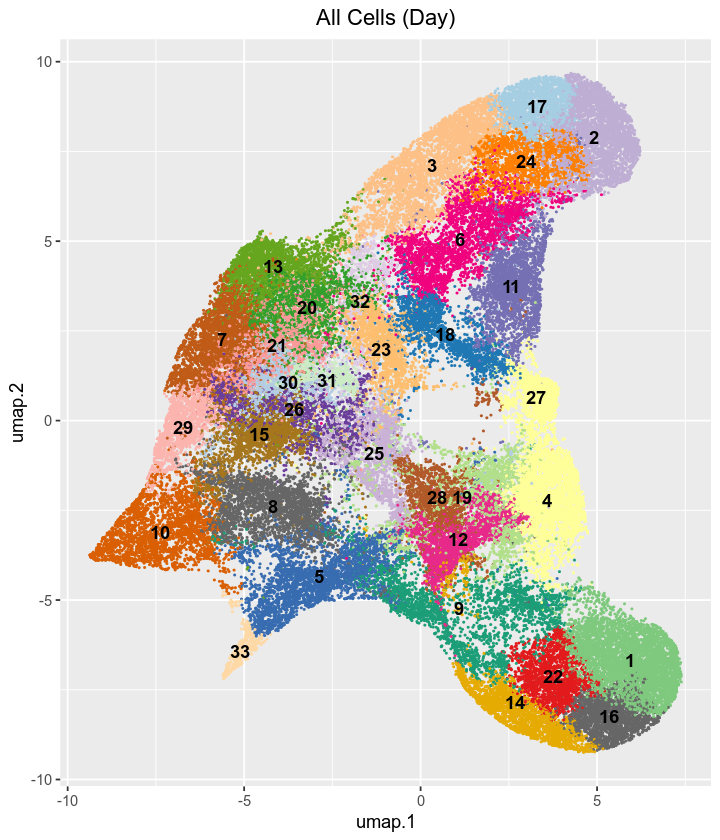

In [59]:
options(repr.plot.width = 6, repr.plot.height = 7)

df = data.frame(x.sp@umap, clst=as.factor(clusters))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=clst)) +
# scale_color_brewer( palette = "Set1") +
scale_color_manual(values=col_vector) +
geom_text(data=data.frame(aggregate(x.sp@umap, list(clusters), mean)),
         aes(x=umap.1, y=umap.2, label=Group.1), fontface = "bold") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5),
      legend.positio = "none")
# guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

## Make pseudo-bulk matrix

In [ ]:
agg_matrix = sparseMatrix(i=clusters,
                         j=seq(1,nrow(x.sp)),
                         x=1L,
                         dims=c(length(table(clusters)), nrow(x.sp)))

In [ ]:
cts = as.matrix(agg_matrix %*% x.sp@pmat)
colnames(cts) = as.character(x.sp@peak)
rownames(cts) = paste("cluster", seq(1,nrow(cts)), sep="_")
cts = t(cts)
head(cts)

In [ ]:
cts = cts[rowSums(cts)>50, ]
dim(cts)

In [ ]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts))

In [ ]:
log_norm_cts = log2(1+norm_cts)

## Gene Scores

In [ ]:
library(EnsDb.Hsapiens.v86)

In [ ]:
edb <- EnsDb.Hsapiens.v86

In [ ]:
genes.hg38 = genes(edb, column = "gene_name", filter = GeneBiotypeFilter("protein_coding"))

In [1310]:
prom.hg38 = promoters(genes.hg38, upstream = 2000, downstream = 500)

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
"GRanges object contains 1 out-of-bound range located on sequence MT.
  Note that ranges located on a sequence whose length is unknown (NA) or
  on a circular sequence are not considered out-of-bound (use
  seqlengths() and isCircular() to get the lengths and circularity flags
  of the underlying sequences). You can use trim() to trim these ranges.
  See ?`trim,GenomicRanges-method` for more information."


In [1311]:
head(prom.hg38, 2)

GRanges object with 2 ranges and 3 metadata columns:
                  seqnames        ranges strand |   gene_name         gene_id
                     <Rle>     <IRanges>  <Rle> | <character>     <character>
  ENSG00000186092        1   67091-69590      + |       OR4F5 ENSG00000186092
  ENSG00000279928        1 180393-182892      + |  FO538757.2 ENSG00000279928
                    gene_biotype
                     <character>
  ENSG00000186092 protein_coding
  ENSG00000279928 protein_coding
  -------
  seqinfo: 287 sequences from GRCh38 genome

In [1312]:
tss.hg38 = resize(genes.hg38, width=1, fix='start')
head(tss.hg38, 2)

GRanges object with 2 ranges and 3 metadata columns:
                  seqnames    ranges strand |   gene_name         gene_id
                     <Rle> <IRanges>  <Rle> | <character>     <character>
  ENSG00000186092        1     69091      + |       OR4F5 ENSG00000186092
  ENSG00000279928        1    182393      + |  FO538757.2 ENSG00000279928
                    gene_biotype
                     <character>
  ENSG00000186092 protein_coding
  ENSG00000279928 protein_coding
  -------
  seqinfo: 287 sequences from GRCh38 genome

In [1313]:
intervals_gr = GRanges(sub("chr", "", rownames(cts)))

### Promoters Only

In [1314]:
overlaps = findOverlaps(prom.hg38, intervals_gr)
overlaps

Hits object with 32345 hits and 0 metadata columns:
          queryHits subjectHits
          <integer>   <integer>
      [1]         2           3
      [2]         2           4
      [3]         6          49
      [4]         6          50
      [5]         7          70
      ...       ...         ...
  [32341]     22252      457266
  [32342]     22255      457288
  [32343]     22261      457451
  [32344]     22262      457465
  [32345]     22262      457466
  -------
  queryLength: 22285 / subjectLength: 457477

In [1315]:
summed_gene = aggregate(cts[subjectHits(overlaps),], list(queryHits(overlaps)), sum)

# remove genes with duplicate entries
summed_gene = summed_gene[!duplicated(prom.hg38[summed_gene$Group.1]$gene_name) ,]
rownames(summed_gene) = prom.hg38[summed_gene$Group.1]$gene_name
summed_gene$Group.1 = NULL

# DESeq2 normalize
summed_gene = as.data.frame(t(t(summed_gene)/estimateSizeFactorsForMatrix(summed_gene)))

head(summed_gene)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6
FO538757.2  34.49093 125.19681  49.76573  21.09179  34.59941  59.41960
SAMD11     187.48042 110.17319  99.53146 292.87450 179.91694 140.79863
NOC2L      536.48769 393.95263 332.07314 520.66578 472.08976 409.47858
KLHL17     536.48769 393.95263 332.07314 520.66578 472.08976 409.47858
PLEKHN1    377.00981 300.47235 251.54314 489.93204 632.01593 262.22130
PERM1      100.05786  66.77163  56.09955  90.99599  77.65646  90.42114
           cluster_7 cluster_8 cluster_9 cluster_10 ⋯ cluster_24 cluster_25
FO538757.2  53.42121  21.12235  29.69232  39.65815  ⋯  98.67687   27.06990 
SAMD11     129.46787 159.79514 194.64962 183.41896  ⋯ 113.57150  216.55922 
NOC2L      463.19329 461.93652 422.29070 475.89783  ⋯ 441.25319  534.08185 
KLHL17     463.19329 461.93652 422.29070 475.89783  ⋯ 441.25319  534.08185 
PLEKHN1    300.41573 613.46639 628.48733 461.02603  ⋯ 323.95804  583.83194 
PERM1       62.84848  67.04049  77.52993  67.98540  ⋯  74.47311   87.06266 
           cluster_26 cluster_27 cluster_28 cluster_29 cluster_30 cluster_31
FO538757.2  49.31054   20.60588   41.86191   46.45229   44.47097   37.70816 
SAMD11     177.51793  254.13920  234.24855  154.42248  159.81753  180.37069 
NOC2L      461.05350  388.07743  545.09549  493.39867  468.33486  482.03594 
KLHL17     461.05350  388.07743  545.09549  493.39867  468.33486  482.03594 
PLEKHN1    425.30337  597.57055  635.94474  325.16604  379.39293  519.11563 
PERM1       81.36238   44.64608  101.53740   60.26243   86.16250   77.30172 
           cluster_32 cluster_33
FO538757.2  50.83820   74.58612 
SAMD11     163.29847  431.53396 
NOC2L      479.11155  580.70619 
KLHL17     479.11155  580.70619 
PLEKHN1    397.46231  559.39587 
PERM1       97.05475  101.22401

### Inverse Distance Model

In [1381]:
distal_overlaps = findOverlaps(tss.hg38+1000000, intervals_gr)
distal_overlaps

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
"GRanges object contains 813 out-of-bound ranges located on sequences 1,
  10, 11, 12, 13, 15, 16, 17, 18, 19, 2, 20, 21, 22, 3, 4, 5, 6, 7, 8, 9,
  CHR_HG1311_PATCH, CHR_HG2023_PATCH, CHR_HG2288_HG2289_PATCH,
  CHR_HSCHR11_1_CTG8, CHR_HSCHR11_2_CTG1, CHR_HSCHR11_3_CTG1,
  CHR_HSCHR12_1_CTG1, CHR_HSCHR12_2_CTG1, CHR_HSCHR13_1_CTG5,
  CHR_HSCHR16_CTG2, CHR_HSCHR17_1_CTG1, CHR_HSCHR17_1_CTG9,
  CHR_HSCHR17_2_CTG1, CHR_HSCHR17_2_CTG2, CHR_HSCHR17_3_CTG2,
  CHR_HSCHR18_3_CTG2_1, CHR_HSCHR19_5_CTG2, CHR_HSCHR1_2_CTG32_1,
  CHR_HSCHR1_ALT2_1_CTG32_1, CHR_HSCHR20_1_CTG3, CHR_HSCHR20_1_CTG4,
  CHR_HSCHR21_5_CTG2, CHR_HSCHR2_3_CTG15, CHR_HSCHR3_2_CTG3,
  CHR_HSCHR4_11_CTG12, CHR_HSCHR4_6_CTG12, CHR_HSCHR5_5_CTG1,
  CHR_HSCHR6_1_CTG5, CHR_HSCHR7_1_CTG1, CHR_HSCHR7_1_CTG7,
  CHR_HSCHR7_2_CTG1, CHR_HSCHR8_2_CTG7, CHR_HSCHR8_4_CTG1,
  CHR_HSCHRX_1_CTG3, CHR_HSCHRX_2_CTG3, GL000009.2, GL000194.1,
  GL000195.1, GL000205.2, GL0002

Hits object with 8000520 hits and 0 metadata columns:
            queryHits subjectHits
            <integer>   <integer>
        [1]         1           1
        [2]         1           2
        [3]         1           3
        [4]         1           4
        [5]         1           5
        ...       ...         ...
  [8000516]     22271      457474
  [8000517]     22272      457474
  [8000518]     22273      457474
  [8000519]     22274      457474
  [8000520]     22275      457474
  -------
  queryLength: 22285 / subjectLength: 457477

In [1382]:
distal_summed_gene = cts[subjectHits(distal_overlaps),]

gene_peak_coeff = 1000*(1+abs(mid(intervals_gr[subjectHits(distal_overlaps)]) - start(tss.hg38[queryHits(distal_overlaps)])))^(-0.7)

distal_summed_gene = aggregate(gene_peak_coeff * distal_summed_gene, list(queryHits(distal_overlaps)), sum)

# remove genes with duplicate entries
distal_summed_gene = distal_summed_gene[!duplicated(tss.hg38[distal_summed_gene$Group.1]$gene_name) ,]
rownames(distal_summed_gene) = tss.hg38[distal_summed_gene$Group.1]$gene_name
distal_summed_gene$Group.1 = NULL

# DESeq2 normalize
distal_summed_gene = as.data.frame(t(t(distal_summed_gene)/estimateSizeFactorsForMatrix(distal_summed_gene)))

head(distal_summed_gene, 2)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6
OR4F5       702.2192  731.5629  542.3125  768.8408  834.0449  673.9791
FO538757.2 1247.3761 1913.1472 1153.0784 1196.7213 1452.3837 1422.9215
           cluster_7 cluster_8 cluster_9 cluster_10 ⋯ cluster_24 cluster_25
OR4F5       672.9145  735.7652  712.9465  729.9032  ⋯  658.8725   752.6738 
FO538757.2 1331.3424 1195.6531 1282.8818 1287.1121  ⋯ 1645.8517  1259.6039 
           cluster_26 cluster_27 cluster_28 cluster_29 cluster_30 cluster_31
OR4F5       757.4311   750.2277   726.1501   696.1241   721.7497   683.0802 
FO538757.2 1451.9033  1166.6469  1316.0667  1312.0855  1342.7891  1263.2234 
           cluster_32 cluster_33
OR4F5       668.1219  1263.471  
FO538757.2 1311.7719  2421.049

In [1569]:
GENE = "COL1A1"

In [1570]:
# distal_summed_gene[GENE, ]
summed_gene[GENE, ]

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6 cluster_7
COL1A1 299.1491  46.74014  39.81258  280.2194  212.9786  50.37749  28.28182 
       cluster_8 cluster_9 cluster_10 ⋯ cluster_24 cluster_25 cluster_26
COL1A1 132.2443  283.7266  112.6008   ⋯ 37.23656   128.7649   109.7159  
       cluster_27 cluster_28 cluster_29 cluster_30 cluster_31 cluster_32
COL1A1 240.4019   244.9367   32.64215   126.4643   142.0341   47.7571   
       cluster_33
COL1A1 90.56886

In [1571]:
max(distal_summed_gene[GENE, ])/min(distal_summed_gene[GENE, ])
max(summed_gene[GENE, ])/min(summed_gene[GENE, ])

[1] 2.530394

[1] 10.57744

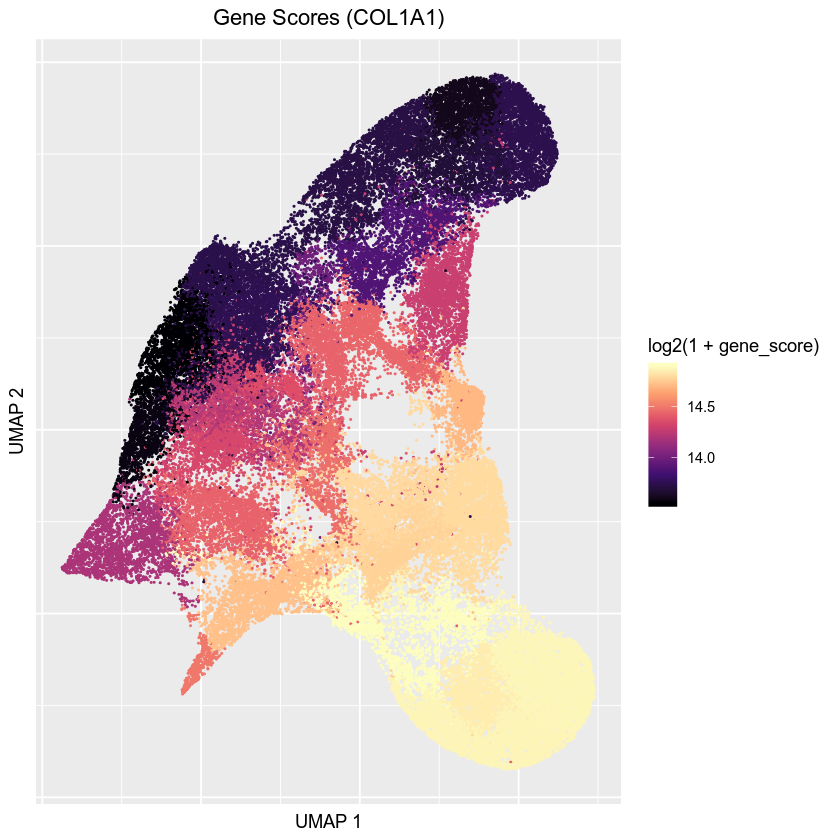

In [1572]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, gene_score=as.numeric(distal_summed_gene[GENE, ])[clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=log2(1+gene_score))) +
ggtitle(sprintf("Gene Scores (%s)", GENE)) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

## Cell State Dissection - Playground

In [1562]:
data.use = summed_gene
group = factor(colnames(data.use), levels = colnames(data.use))
y = DGEList(counts=data.use, group=group)

In [1563]:
design <- model.matrix(~0+group, data=y$samples)
colnames(design) <- levels(y$samples$group)

In [1564]:
fit <- glmFit(y, design, dispersion = 0.4^2)

In [1565]:
# contrast vector (1-vs-all)
cont = rep(-1/(ncol(data.use)-1),ncol(data.use))
cont[(group %in% c("cluster_10"))] = 1

In [958]:
# contrast vector (1-vs-1)
cont = rep(0,ncol(data.use))
cont[(group %in% c("cluster_29"))] = 1
cont[(group %in% c("cluster_10"))] = -1

In [1566]:
# one-vs-all for a cluster
lrt <- glmLRT(fit, contrast=cont)

In [1567]:
cur_diff_peaks = rownames(lrt$table[order((1/lrt$table$PValue)*ifelse(lrt$table$logFC>0, -1, 1)),])  

In [1568]:
head(cur_diff_peaks, 40)

[1] "DEFB134"    "SIAE"       "TXNRD3NB"   "AFP"        "NAALAD2"   
 [6] "CRYGA"      "FP325331.1" "AL137164.1" "HCRTR2"     "C1orf105"  
[11] "C3orf22"    "HMGCS2"     "L3MBTL3"    "CCDC168"    "SLC9B2"    
[16] "LCT"        "KCTD18"     "AC023283.1" "SLC26A7"    "ABCC2"     
[21] "KLF12"      "NOXRED1"    "TMEM202"    "MPEG1"      "APBA2"     
[26] "OR13D1"     "GOLGA1"     "SPG20"      "SOSTDC1"    "CLDN22"    
[31] "LRRC66"     "PDP2"       "VGLL1"      "KCNH5"      "ROS1"      
[36] "NSRP1"      "AC073072.1" "ARHGAP29"   "GHRL"       "OR6X1"

In [1557]:
cur_diff_peaks[100]

[1] "CLCA2"

In [1560]:
GENE = "ACMSD"
min(as.numeric(data.use[GENE, ]))
median(as.numeric(data.use[GENE, ]))
max(as.numeric(data.use[GENE, ]))
max(as.numeric(data.use[GENE, ]))/min(as.numeric(data.use[GENE, ]))
data.use[GENE, ]

[1] 1552.722

[1] 2144.495

[1] 8047.246

[1] 5.182671

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6 cluster_7
ACMSD 1951.251  2008.32   1917.458  1819.342  2747.487  2092.59   2531.566 
      cluster_8 cluster_9 cluster_10 ⋯ cluster_24 cluster_25 cluster_26
ACMSD 2825.923  2345.635  8047.246   ⋯ 2144.495   2339.448   1858.765  
      cluster_27 cluster_28 cluster_29 cluster_30 cluster_31 cluster_32
ACMSD 2523.862   3166.09    2554.425   2043.735   2361.102   1891.983  
      cluster_33
ACMSD 1552.722

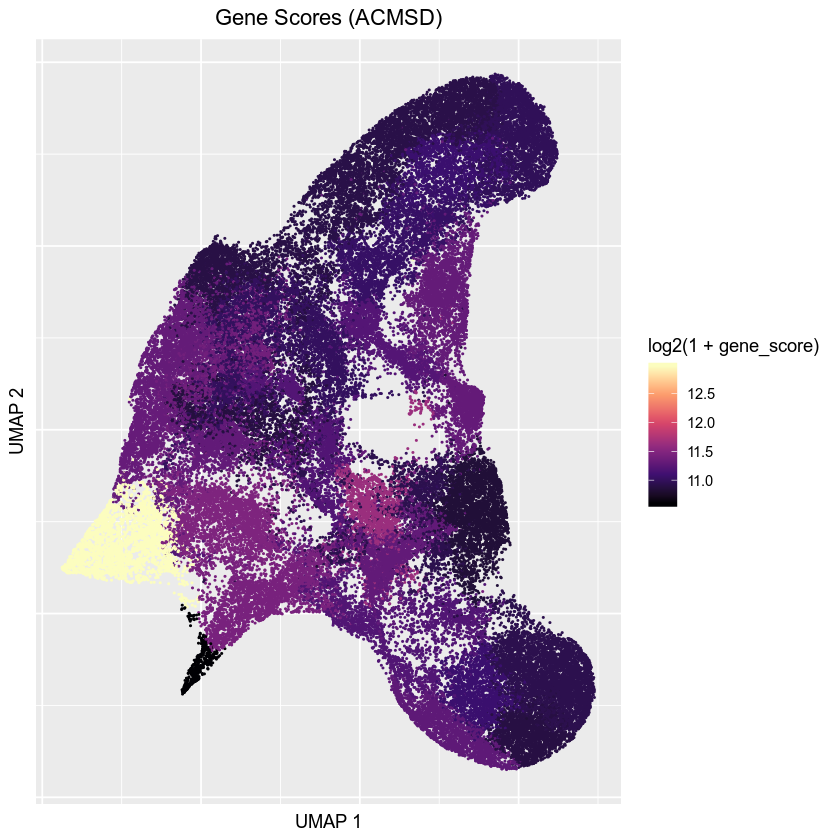

In [1561]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, gene_score=as.numeric(data.use[GENE, ])[clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=log2(1+gene_score))) +
ggtitle(sprintf("Gene Scores (%s)", GENE)) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

In [1426]:
ALL_PEAKS_BED_PATH = "tmp.txt"
fileConn = file(ALL_PEAKS_BED_PATH)
writeLines((cur_diff_peaks)[1:300], fileConn)
close(fileConn)

In [1328]:
ALL_PEAKS_BED_PATH = "tmp_all.txt"
fileConn = file(ALL_PEAKS_BED_PATH)
writeLines(rownames(distal_summed_gene), fileConn)
close(fileConn)

## Locus Level Analyses (Vignettes)
Analyses a bunch of gene clusters or regions to see aggregate signal in them. Usually doesn't work at single-cell level because regions are not large enough.

In [613]:
peaks_gr = GRanges(rownames(norm_cts))

### Type I Keratin Gene Cluster

Rough coordinates chr17:40801459-41629596. 

In [1403]:
region = "chr17:40801459-41629596"
region_gr = GRanges(c(region))

In [1404]:
norm_reads_in_region = colSums(norm_cts[unique(queryHits(findOverlaps(peaks_gr, region_gr))), ])

In [1405]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)
max(norm_reads_in_region)/min(norm_reads_in_region)

[1] 7182.931

[1] 2213.267

[1] 1769.294

[1] 4.059772

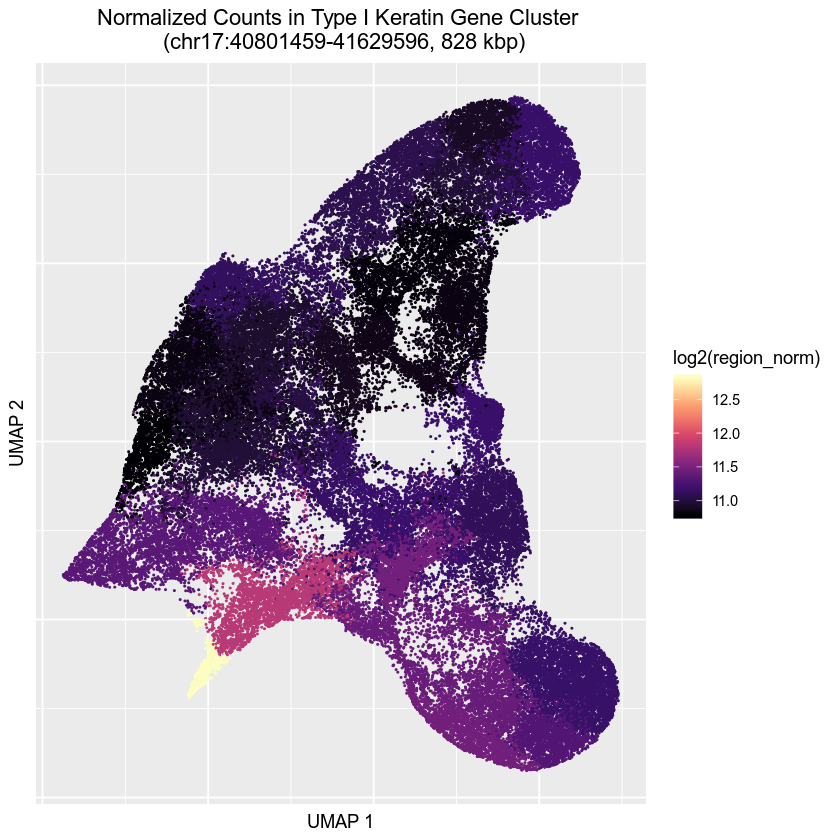

In [1406]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, region_norm=norm_reads_in_region[clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=log2(region_norm))) +
ggtitle(sprintf("Normalized Counts in Type I Keratin Gene Cluster \n (%s, %d kbp)", region, 
               as.integer(width(region_gr)/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

### Type II Keratin Gene Cluster

In [1399]:
region = "chr12:52138667-52987560"
region_gr = GRanges(c(region))

In [1400]:
norm_reads_in_region = colSums(norm_cts[unique(queryHits(findOverlaps(peaks_gr, region_gr))), ])

In [1401]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)
max(norm_reads_in_region)/min(norm_reads_in_region)

[1] 18640.46

[1] 9687.823

[1] 7930.4

[1] 2.350507

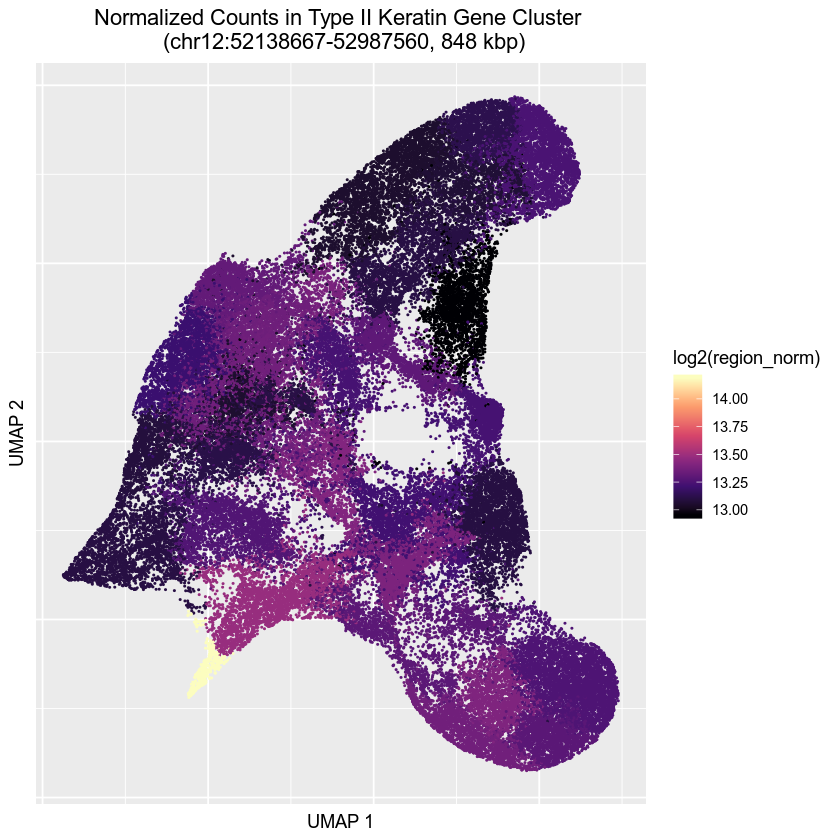

In [1402]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, region_norm=norm_reads_in_region[clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=log2(region_norm))) +
ggtitle(sprintf("Normalized Counts in Type II Keratin Gene Cluster \n (%s, %d kbp)", region, 
               as.integer(width(region_gr)/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

### Type 1 Interferon Locus

In [678]:
region = "chr9:21053568-21498318"
region_gr = GRanges(c(region))

In [679]:
norm_reads_in_region = colSums(norm_cts[unique(queryHits(findOverlaps(peaks_gr, region_gr))), ])

In [680]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)
max(norm_reads_in_region)/min(norm_reads_in_region)

[1] 3361.933

[1] 1736.506

[1] 1327.96

[1] 2.531652

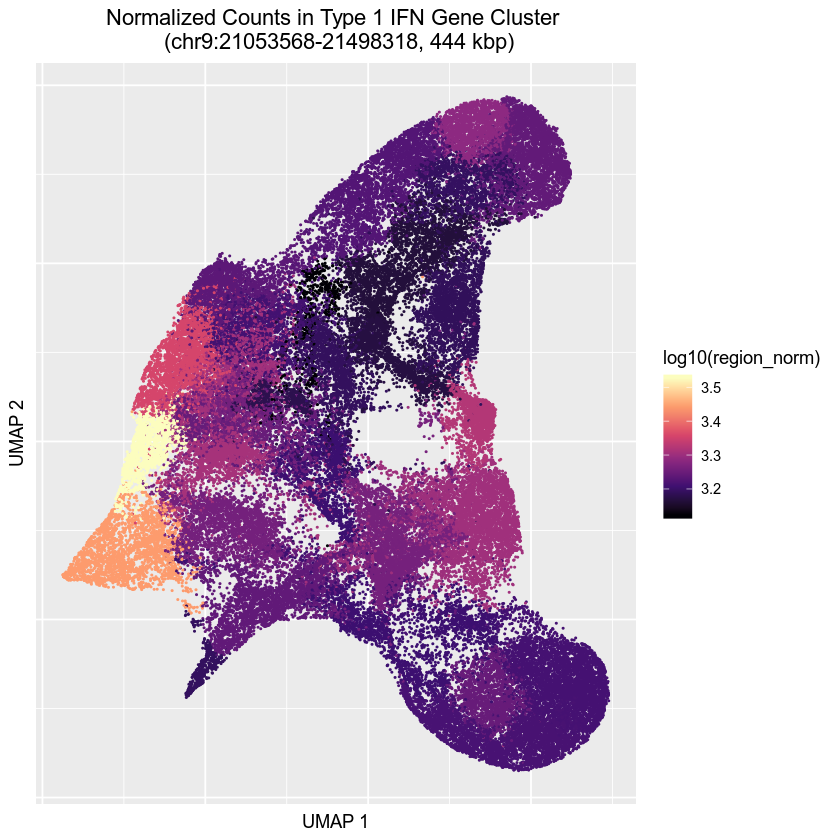

In [616]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, region_norm=norm_reads_in_region[clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=log10(region_norm))) +
ggtitle(sprintf("Normalized Counts in Type 1 IFN Gene Cluster \n (%s, %d kbp)", region, 
               as.integer(width(region_gr)/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

### Promoters of Olfactory Receptor Genes

In [1616]:
prom.hg38 = promoters(genes.hg38, upstream = 2000, downstream = 500)
seqlevels(prom.hg38) = paste("chr", seqlevels(prom.hg38), sep='')

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
"GRanges object contains 1 out-of-bound range located on sequence MT.
  Note that ranges located on a sequence whose length is unknown (NA) or
  on a circular sequence are not considered out-of-bound (use
  seqlengths() and isCircular() to get the lengths and circularity flags
  of the underlying sequences). You can use trim() to trim these ranges.
  See ?`trim,GenomicRanges-method` for more information."


In [1617]:
region_gr = prom.hg38[(grepl("^OR[0-9]", prom.hg38$gene_name)),]

In [1367]:
# total olfactory receptors 
length(region_gr)

# those that intersect with any peaks
length(unique(subjectHits(findOverlaps(peaks_gr, region_gr))))

[1] 471

[1] 35

In [1626]:
norm_reads_in_region = colSums(norm_cts[unique(queryHits(findOverlaps(peaks_gr, region_gr))), ])

In [1627]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)
max(norm_reads_in_region)/min(norm_reads_in_region)

[1] 1344.773

[1] 423.642

[1] 287.719

[1] 4.673912

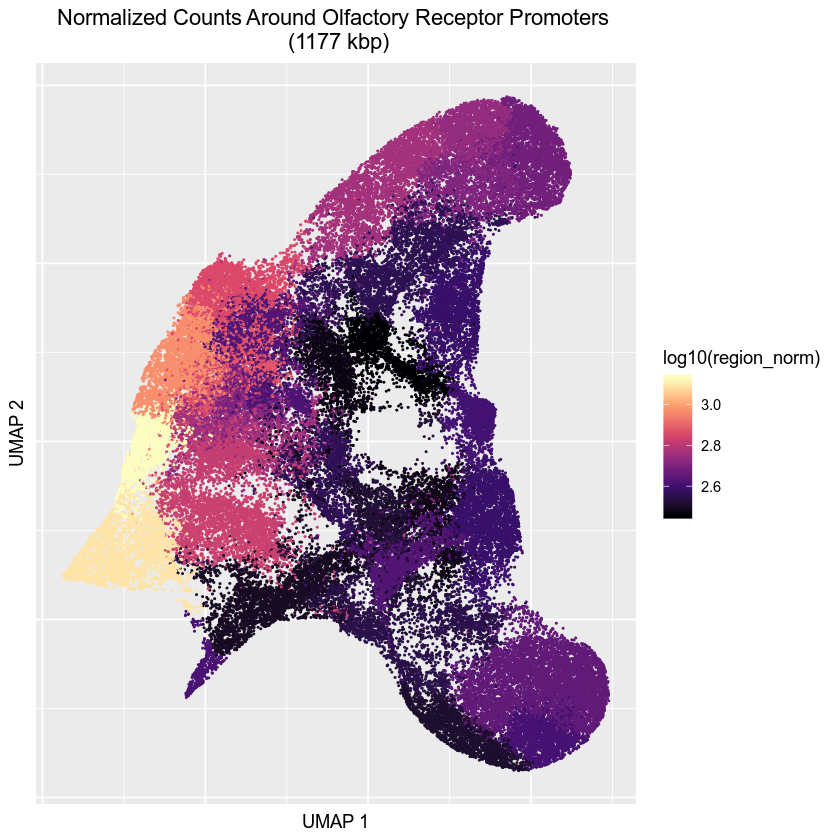

In [1628]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, region_norm=norm_reads_in_region[clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=log10(region_norm))) +
ggtitle(sprintf("Normalized Counts Around Olfactory Receptor Promoters \n (%d kbp)", 
               as.integer(sum(width(region_gr))/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

### Chromosome 6 Histone Gene Cluster Locus

In [698]:
region = "chr6:26009950-26300518"
region_gr = GRanges(c(region))

In [618]:
norm_reads_in_region = colSums(norm_cts[unique(queryHits(findOverlaps(peaks_gr, region_gr))), ])

In [619]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)
max(norm_reads_in_region)/min(norm_reads_in_region)

[1] 21860.1

[1] 18091.88

[1] 14114.71

[1] 1.548746

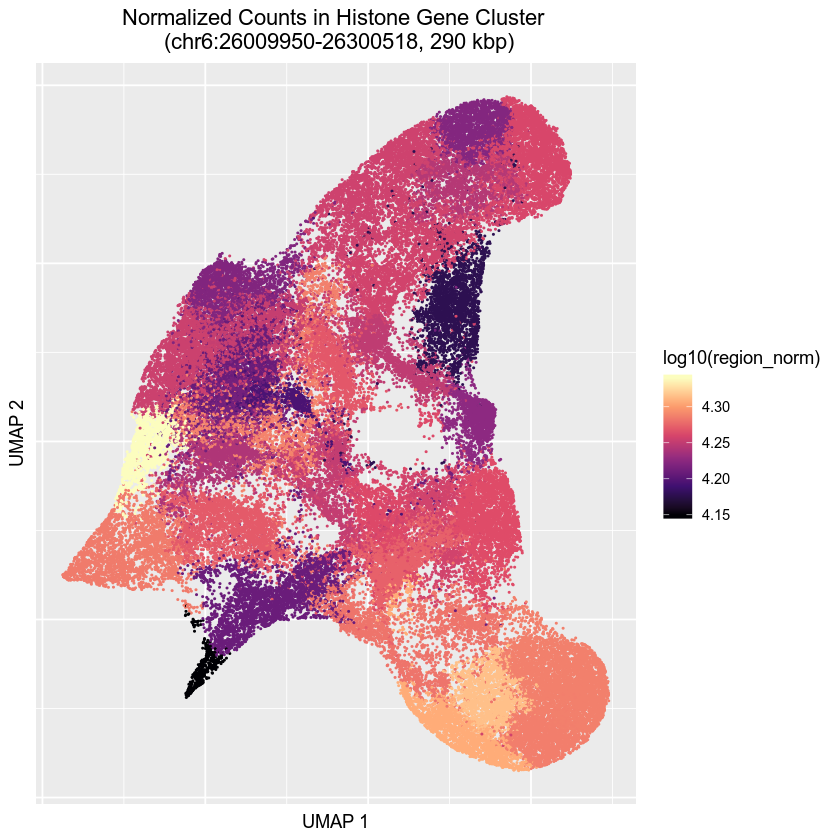

In [620]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, region_norm=norm_reads_in_region[clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=log10(region_norm))) +
ggtitle(sprintf("Normalized Counts in Histone Gene Cluster \n (%s, %d kbp)", region, 
               as.integer(width(region_gr)/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

### Soufi et al "DBR" Heterochromatin Regions

These were regions identified in Soufi et al 2012 that were recfractory to OSKM binding in fibroblasts and are marked by H3K9me3, and are required for reprogramming. This can be done at single-cell level since it is 500 Mbp combined.

In [652]:
region_gr = read.table("../../../resources/GSE36570/DBRs.hg38.bed")
colnames(region_gr) = c("chr", "start", "end")
region_gr = makeGRangesFromDataFrame(region_gr)

In [657]:
norm_reads_in_region = Matrix::rowSums(x.sp@pmat[, unique(queryHits(findOverlaps(GRanges(as.character(x.sp@peak)), region_gr)))])/Matrix::rowSums(x.sp@pmat)

In [658]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)
max(norm_reads_in_region)/min(norm_reads_in_region)

[1] 0.09594096

[1] 0.02569026

[1] 0.00228833

[1] 41.9262

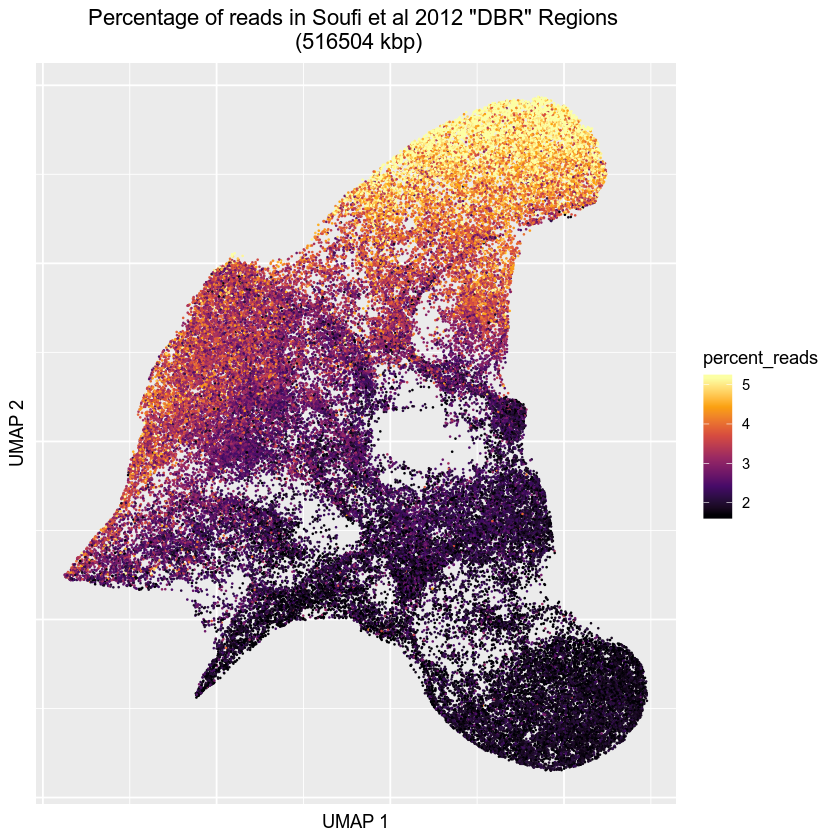

In [677]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, percent_reads=100*norm_reads_in_region)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.1, alpha=1, aes(x=umap.1 , y=umap.2, col=percent_reads)) +
ggtitle(sprintf("Percentage of reads in Soufi et al 2012 \"DBR\" Regions \n (%d kbp)",  
               as.integer(sum(width(region_gr))/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(quantile(100*norm_reads_in_region, 0.1), 
                               quantile(100*norm_reads_in_region, 0.95)), 
                      oob=squish, option = "B") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

### Reads in Clustered Peak Sets

In [1467]:
region_gr = read.table("../20200307_fine_clustering/beds/20200307_gridmap_naive_n15/idx15.bed")
colnames(region_gr) = c("chr", "start", "end")
region_gr = makeGRangesFromDataFrame(region_gr)

In [1468]:
norm_reads_in_region = Matrix::rowSums(x.sp@pmat[, unique(queryHits(findOverlaps(GRanges(as.character(x.sp@peak)), region_gr)))])/Matrix::rowSums(x.sp@pmat)

In [1469]:
max(norm_reads_in_region)
median(norm_reads_in_region)
min(norm_reads_in_region)
max(norm_reads_in_region)/min(norm_reads_in_region)

[1] 0.1588568

[1] 0.003460208

[1] 0

[1] Inf

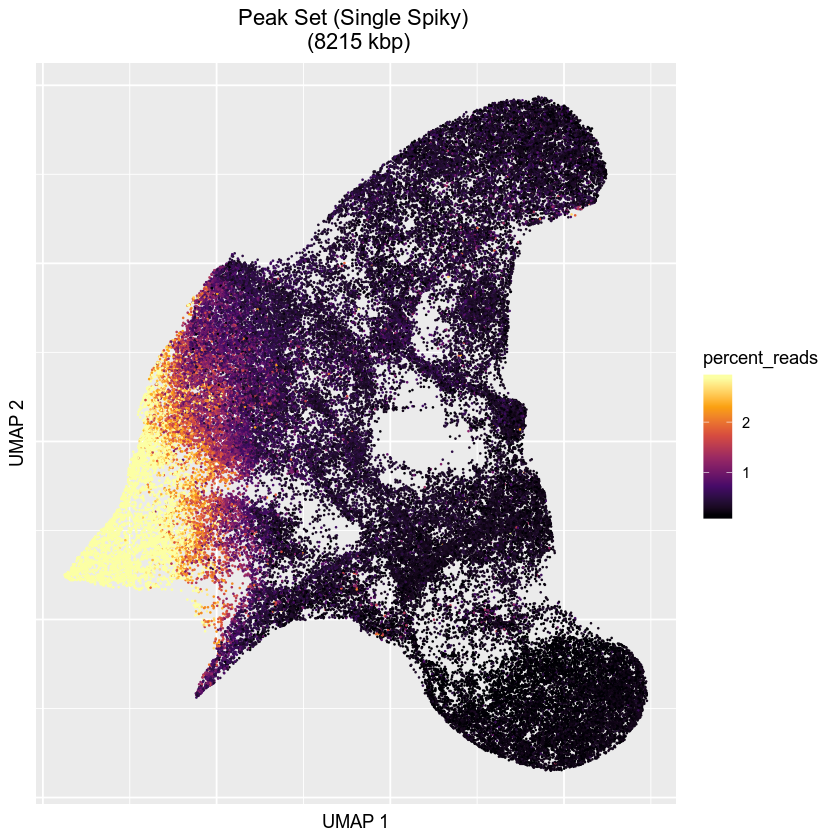

In [1470]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, percent_reads=100*norm_reads_in_region)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$percent_reads<2, ]) +
geom_point(size=0.1, alpha=1, aes(x=umap.1 , y=umap.2, col=percent_reads)) +
ggtitle(sprintf("Peak Set (Single Spiky) \n (%d kbp)",  
               as.integer(sum(width(region_gr))/1000))) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits= c(quantile(100*norm_reads_in_region, 0.1), 
                               quantile(100*norm_reads_in_region, 0.95)), 
                      oob=squish, option = "B") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

In [1615]:
# using old metadata to annotate (these clusters were used to call peaks)

# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
old_metaData = read.table("../20200122_snapATAC/snapATAC_sessions/20200125_n76770/metadata.tsv", header = T)
rownames(old_metaData) =  paste(old_metaData$sample, old_metaData$barcode, sep='_')
old_metaData = old_metaData[rownames(metaData), ]
head(old_metaData, 2)

barcode          cluster umap1    umap2    barcode.1       
D0_AAACAACGACGATTAC AAACAACGACGATTAC 6       2.515876 8.252824 AAACAACGACGATTAC
D0_AAACAACGACTCACGG AAACAACGACTCACGG 6       2.355841 7.403916 AAACAACGACTCACGG
                    TN    UM    PP    UQ    CM landmark cluster.1 sample
D0_AAACAACGACGATTAC 42629 38455 38381 33575 51 0        6         D0    
D0_AAACAACGACTCACGG  4424  4009  3998  3694  4 0        6         D0

In [1430]:
sum(is.na(old_metaData$cluster.1))

[1] 330

Warning message:
"Removed 330 rows containing missing values (geom_point)."


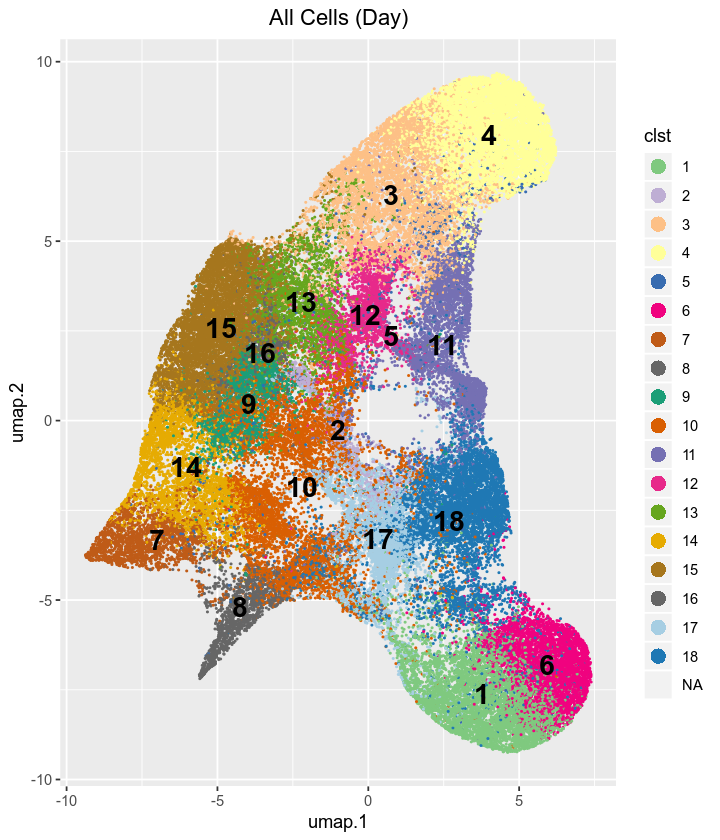

In [1475]:
options(repr.plot.width = 6, repr.plot.height = 7)

df = data.frame(x.sp@umap, clst=as.factor(old_metaData$cluster.1))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=clst)) +
# scale_color_brewer( palette = "Set1") +
scale_color_manual(values=col_vector) +
geom_text(data=data.frame(aggregate(x.sp@umap, list(old_metaData$cluster.1), mean)),
         aes(x=umap.1, y=umap.2, label=Group.1), size=6, fontface = "bold") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) +
#       legend.positio = "none")
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

## D0 Diff Peaks

In [1629]:
data.use = cts[, c("cluster_1", "cluster_14")]
group = factor(colnames(data.use), levels = colnames(data.use))
design = model.matrix(~0+group)
y = DGEList(counts=data.use, group=group)
et = exactTest(y, dispersion = 0.4^2)
cur_diff_peaks = rownames(et$table[order((1/et$table$PValue)*ifelse(et$table$logFC>0, 1, -1)),])  

In [1630]:
frac_in_peakset = Matrix::rowSums(x.sp@pmat[, as.character(x.sp@peak) %in% cur_diff_peaks[1:10000]])/Matrix::rowSums(x.sp@pmat)

In [1631]:
frac_in_peakset_rev = Matrix::rowSums(x.sp@pmat[, as.character(x.sp@peak) %in% rev(cur_diff_peaks)[1:10000]])/Matrix::rowSums(x.sp@pmat)

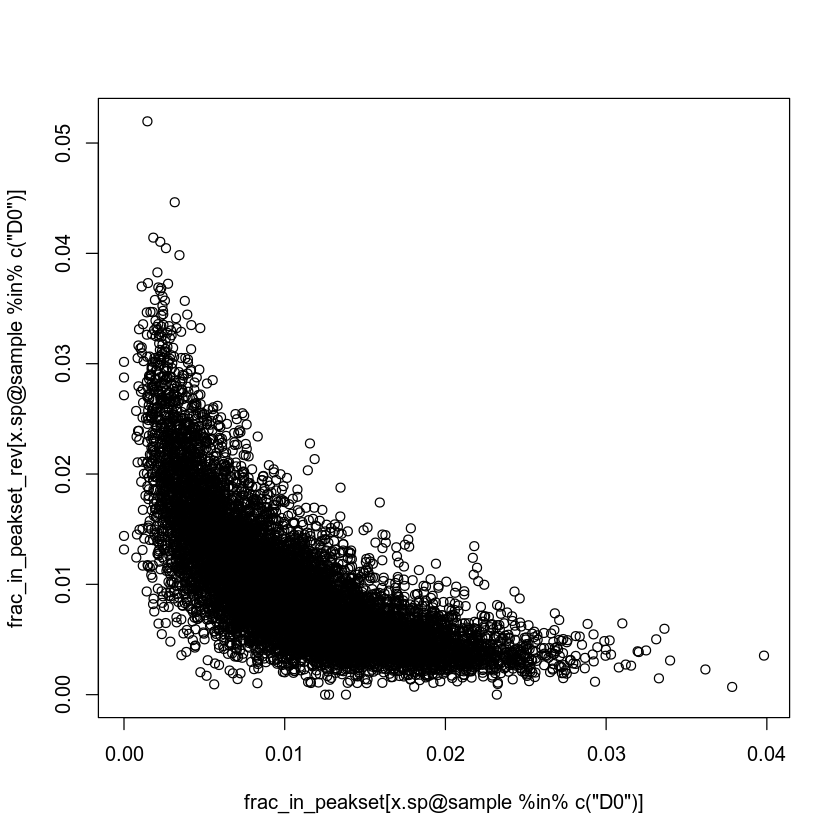

In [1634]:
plot(frac_in_peakset[x.sp@sample %in% c("D0")], frac_in_peakset_rev[x.sp@sample %in% c("D0")])

In [1638]:
options(repr.plot.width = 7, repr.plot.height = 7)
selected_cluster_id = 10

twoplots = list()
i=1
cur_days = c("D0", "D2")
for (toplot in list(frac_in_peakset, frac_in_peakset_rev)) {

    # df = data.frame(x.sp@umap, accs=km_mb$centroids[selected_cluster_id, ][clusters])
    cur_selected = toplot[x.sp@sample %in% cur_days]
    cur_med = quantile(cur_selected, 0.5)

    # or a specific peak
    # df = data.frame(x.sp@umap, accs=log2(1+colSums(norm_cts[rev(cur_diff_peaks)[1:1000], ]))[clusters])
    df = data.frame(x.sp@umap, x.sp@sample, frip=toplot)
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1]), ]

    # ggplot(df) +
    twoplots[[i]] <- ggplot(df[df$x.sp.sample %in% cur_days, ]) +
    geom_point(size=0.1, alpha=1, aes(x=umap.1 , y=umap.2, col=frip)) +
    ggtitle(sprintf("Fraction of Reads in Peak Set %d (per cell)", i)) + 
    xlab("UMAP 1") + ylab("UMAP 2") +
    scale_color_viridis_c(limits=c(0, quantile(cur_selected, 0.98)), oob=squish, option = "A") +
    theme(plot.title = element_text(hjust = 0.5))
    
    i = i+1
}

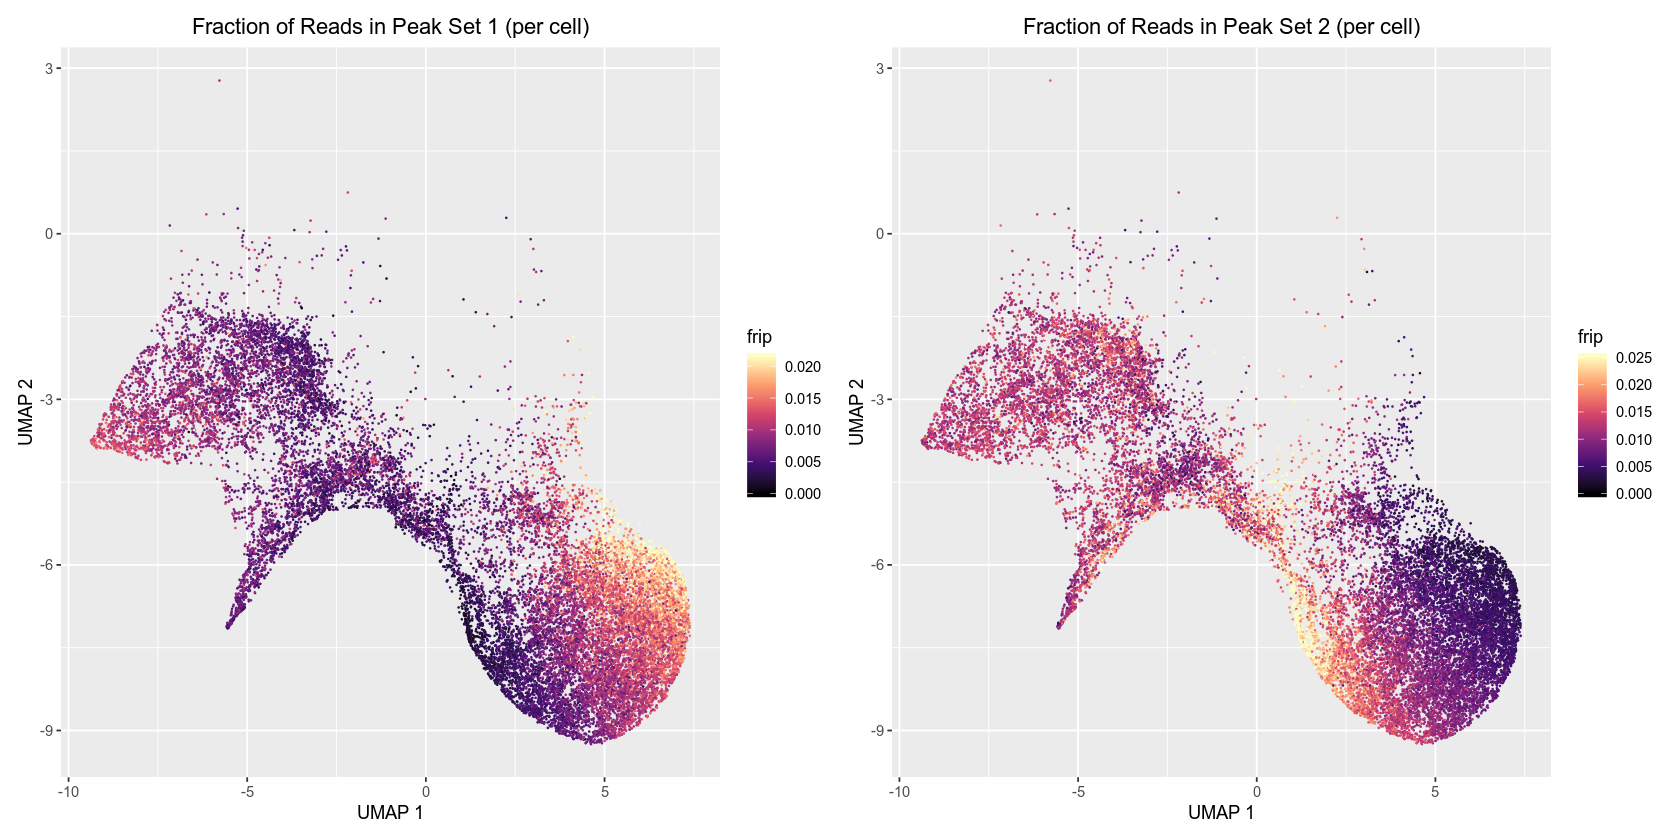

In [1639]:
options(repr.plot.width = 14, repr.plot.height = 7)
wrap_plots(twoplots)